# Class 07: Alternatives to Pandas

  ## Pros and Cons
  `Pandas` is a very strong package for DataFrames that is been heavily used over the las few years. Though Pandas is not without drawbacks.

  ## Pros
  - Huge collection of documentation and user-generated support (think Stack Overflow)
  - Widely used in data science and data analyst communities
  - Great operability with other Python packages
  - Well optimized, operations compile and run in C
  - Can sometimes have dependency issues (e.g. with Numpy)

  ## Cons
  - Hugely memory intensive. It has been said you need 5-10 times the amount of RAM as size of your data
  - Once you get into the tens and hundreds of millions of records, Pandas becomes very slow
  - Not a lot of support for `parallel computation`
  - Not a lot of support for `lazy computations`. e.g. all the data must be in memory!



## A few quick definitions


### `parallel computation`
*Parallel computing is a method of solving problems by splitting them into smaller tasks that are processed simultaneously by multiple processors*

### `lazy computations`
*Computations that are not executed immediately but are instead queued up as a task graph, only being performed when explicitly requested*

## Overview of Alternatives to Pandas
1. Dask
2. Polars

# Intro to [Dask](https://tutorial.dask.org/01_dataframe.html)
<img src="https://cdn.prod.website-files.com/655926fa24195711dbf38624/655926fa24195711dbf38653_dask-header-logo.svg"/>

### Dask DataFrame - parallelized pandas
Looks and feels like the `pandas` API, but for parallel and distributed workflows.

At its core, the `dask.dataframe` module implements a “blocked parallel” `DataFrame` object that looks and feels like the pandas API, but for parallel and distributed workflows. One `Dask DataFrame` is comprised of many in-memory `pandas DataFrames` separated along the index. One operation on a Dask DataFrame triggers many pandas operations on the constituent pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.

<br><br>
<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg" alt="drawing" width="300"/>

### When to use dask.dataframe
#### Dask DataFrames are often used either when …
1. Your data is too big
2. Your computation is too slow and other techniques don’t work

#### You should probably stick to just using pandas if …
1. Your data is small
2. Your computation is fast (subsecond)
3. There are simpler ways to accelerate your computation, like avoiding .apply or Python for loops and using a built-in pandas method instead.
pandas is great for tabular datasets that fit in memory.


A general rule of thumb for pandas is:

```
“Have 5 to 10 times as much RAM as the size of your dataset”
Wes McKinney (2017) in 10 things I hate about pandas
```

Here “size of dataset” means dataset size on the disk.

`Dask becomes useful when the datasets exceed the above rule.`

In this notebook, you will be working with the New York City Airline data. This dataset is only ~200MB, so that you can download it in a reasonable time, but dask.dataframe will scale to datasets much larger than memory.

In [ ]:
!pip install dask

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/MyDrive/Colab Notebooks/2025_Spring_DNSC4211/public/Class_05/Assignment/Data"

Mounted at /content/drive
Crime_Incidents_in_2008.csv  Crime_Incidents_in_2014.csv  Crime_Incidents_in_2020.csv
Crime_Incidents_in_2009.csv  Crime_Incidents_in_2015.csv  Crime_Incidents_in_2021.csv
Crime_Incidents_in_2010.csv  Crime_Incidents_in_2016.csv  Crime_Incidents_in_2022.csv
Crime_Incidents_in_2011.csv  Crime_Incidents_in_2017.csv  Crime_Incidents_in_2023.csv
Crime_Incidents_in_2012.csv  Crime_Incidents_in_2018.csv  Crime_Incidents_in_2024.csv
Crime_Incidents_in_2013.csv  Crime_Incidents_in_2019.csv


In [3]:
import dask.dataframe as dd
import os
path = "/content/drive/MyDrive/Colab Notebooks/2025_Spring_DNSC4211/public/Class_05/Assignment/Data"
data_paths = os.path.join(path, "*.csv")
ddf = dd.read_csv(data_paths)
ddf

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,WARD,ANC,DISTRICT,PSA,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
npartitions=17,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,int64,string,string,string,string,string,int64,int64,int64,string,int64,int64,string,string,int64,string,float64,float64,string,string,string,int64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


`Dask` has not loaded the data yet, it has: - investigated the input path and found that there are 17 matching files - intelligently created a set of jobs for each chunk – one per original CSV file in this case

Notice that the representation of the `DataFrame` object contains no data - `Dask` has just done enough to read the start of the first file, and infer the column names and dtypes.

### Lazy Evaluation
Most `Dask` Collections, including `Dask DataFrame` are evaluated `lazily`, which means `Dask` constructs the logic (called task graph) of your computation immediately but “evaluates” them only when necessary. You can view this task graph using `.visualize()`.

You will learn more about this in the Delayed notebook, but for now, note that we need to call `.compute()` to trigger actual computations.

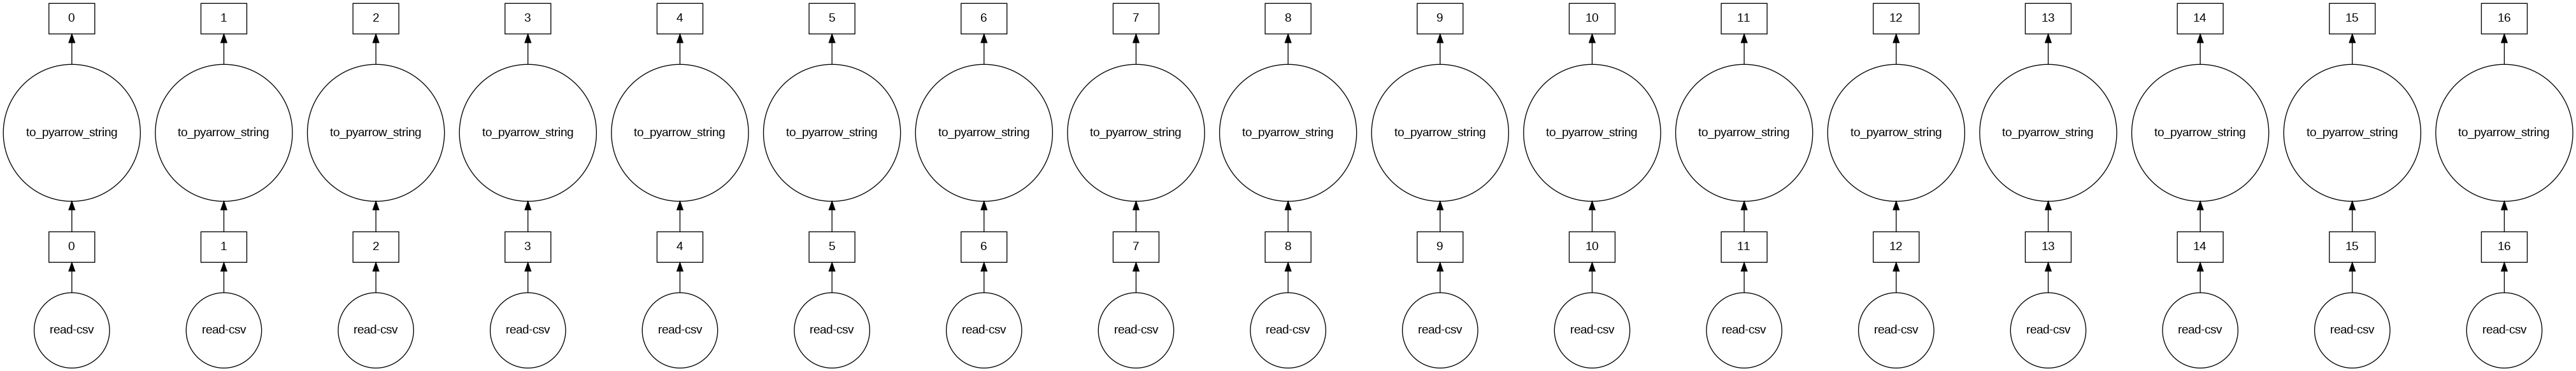

In [4]:
ddf.visualize()

Some functions like `len` and `head` also trigger a `computation`. Specifically, calling len will: - load actual data, (that is, load each file into a pandas DataFrame) - then apply the corresponding functions to each pandas DataFrame (also known as a partition) - combine the subtotals to give you the final grand total

In [5]:
len(ddf)

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+--------------+---------+----------+
| Column       | Found   | Expected |
+--------------+---------+----------+
| CENSUS_TRACT | float64 | int64    |
| DISTRICT     | float64 | int64    |
| PSA          | float64 | int64    |
| XBLOCK       | float64 | int64    |
| YBLOCK       | float64 | int64    |
+--------------+---------+----------+

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CENSUS_TRACT': 'float64',
       'DISTRICT': 'float64',
       'PSA': 'float64',
       'XBLOCK': 'float64',
       'YBLOCK': 'float64'}

to the call to `read_csv`/`read_table`.

Alternatively, provide `assume_missing=True` to interpret
all unspecified integer columns as floats.

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, dask.dataframe.read_csv only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the `datatypes inferred in the sample are inconsistent`.

Specify dtypes directly using the dtype keyword. This is the recommended solution, as it’s the least error prone (better to be explicit than implicit) and also the most performant.

Increase the size of the sample keyword (in bytes)

Use assume_missing to make dask assume that columns inferred to be int (which don’t allow missing values) are actually floats (which do allow missing values). In our particular case this doesn’t apply.

In our case we’ll use the first option and directly specify the dtypes of the offending columns.

In [6]:
dtypes = {
    "CENSUS_TRACT":   float,
    "DISTRICT":       float,
    "PSA":            float,
    "XBLOCK":         float,
    "YBLOCK":         float,
    "WARD":           float
}
ddf = dd.read_csv(data_paths, dtype=dtypes)


In [7]:
len(ddf)

562317

In [8]:
import pandas as pd
pd.set_option("display.max_columns", 100)

In [9]:
ddf.head()

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,WARD,ANC,DISTRICT,PSA,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
0,-76.967206,38.872074,8175440,2008/12/12 22:00:00+00,EVENING,OTHERS,THEFT/OTHER,2800 - 2821 BLOCK OF PENNSYLVANIA AVENUE SE,402846.0,133805.0,7.0,7B,6.0,605.0,Cluster 34,007604 3,7604.0,Precinct 111,38.872067,-76.967204,<NA>,2008/12/12 17:00:00+00,2008/12/12 19:00:00+00,403455675,NaN
1,-76.998459,38.839721,8175469,2008/12/12 21:45:00+00,EVENING,OTHERS,ASSAULT W/DANGEROUS WEAPON,3301 - 3699 BLOCK OF 6TH STREET SE,400134.0,130213.0,8.0,8C,7.0,705.0,Cluster 39,009804 2,9804.0,Precinct 122,38.839713,-76.998457,<NA>,2008/12/12 20:03:00+00,2008/12/12 05:00:00+00,403455676,NaN
2,-77.037529,38.903747,8175472,2008/12/12 21:28:00+00,EVENING,OTHERS,THEFT/OTHER,1600 - 1699 BLOCK OF L STREET NW,396745.0,137321.0,2.0,2B,2.0,207.0,Cluster 6,010700 1,10700.0,Precinct 17,38.903739,-77.037526,GOLDEN TRIANGLE,2008/12/12 16:30:00+00,2008/12/12 20:30:00+00,403455677,NaN
3,-77.028228,38.940809,8175489,2008/12/13 00:50:00+00,EVENING,OTHERS,THEFT/OTHER,1200 - 1299 BLOCK OF TAYLOR STREET NW,397553.0,141435.0,4.0,4C,4.0,404.0,Cluster 18,002502 1,2502.0,Precinct 47,38.940802,-77.028226,<NA>,2008/12/12 21:15:00+00,2008/12/12 21:30:00+00,403455678,NaN
4,-77.042370,38.921626,8175494,2008/12/12 22:00:00+00,EVENING,OTHERS,THEFT/OTHER,2400 - 2499 BLOCK OF 18TH STREET NW,396326.0,139306.0,1.0,1C,3.0,303.0,Cluster 1,004002 1,4002.0,Precinct 25,38.921619,-77.042367,ADAMS MORGAN,2008/01/07 23:00:00+00,2008/01/07 23:20:00+00,403455679,NaN


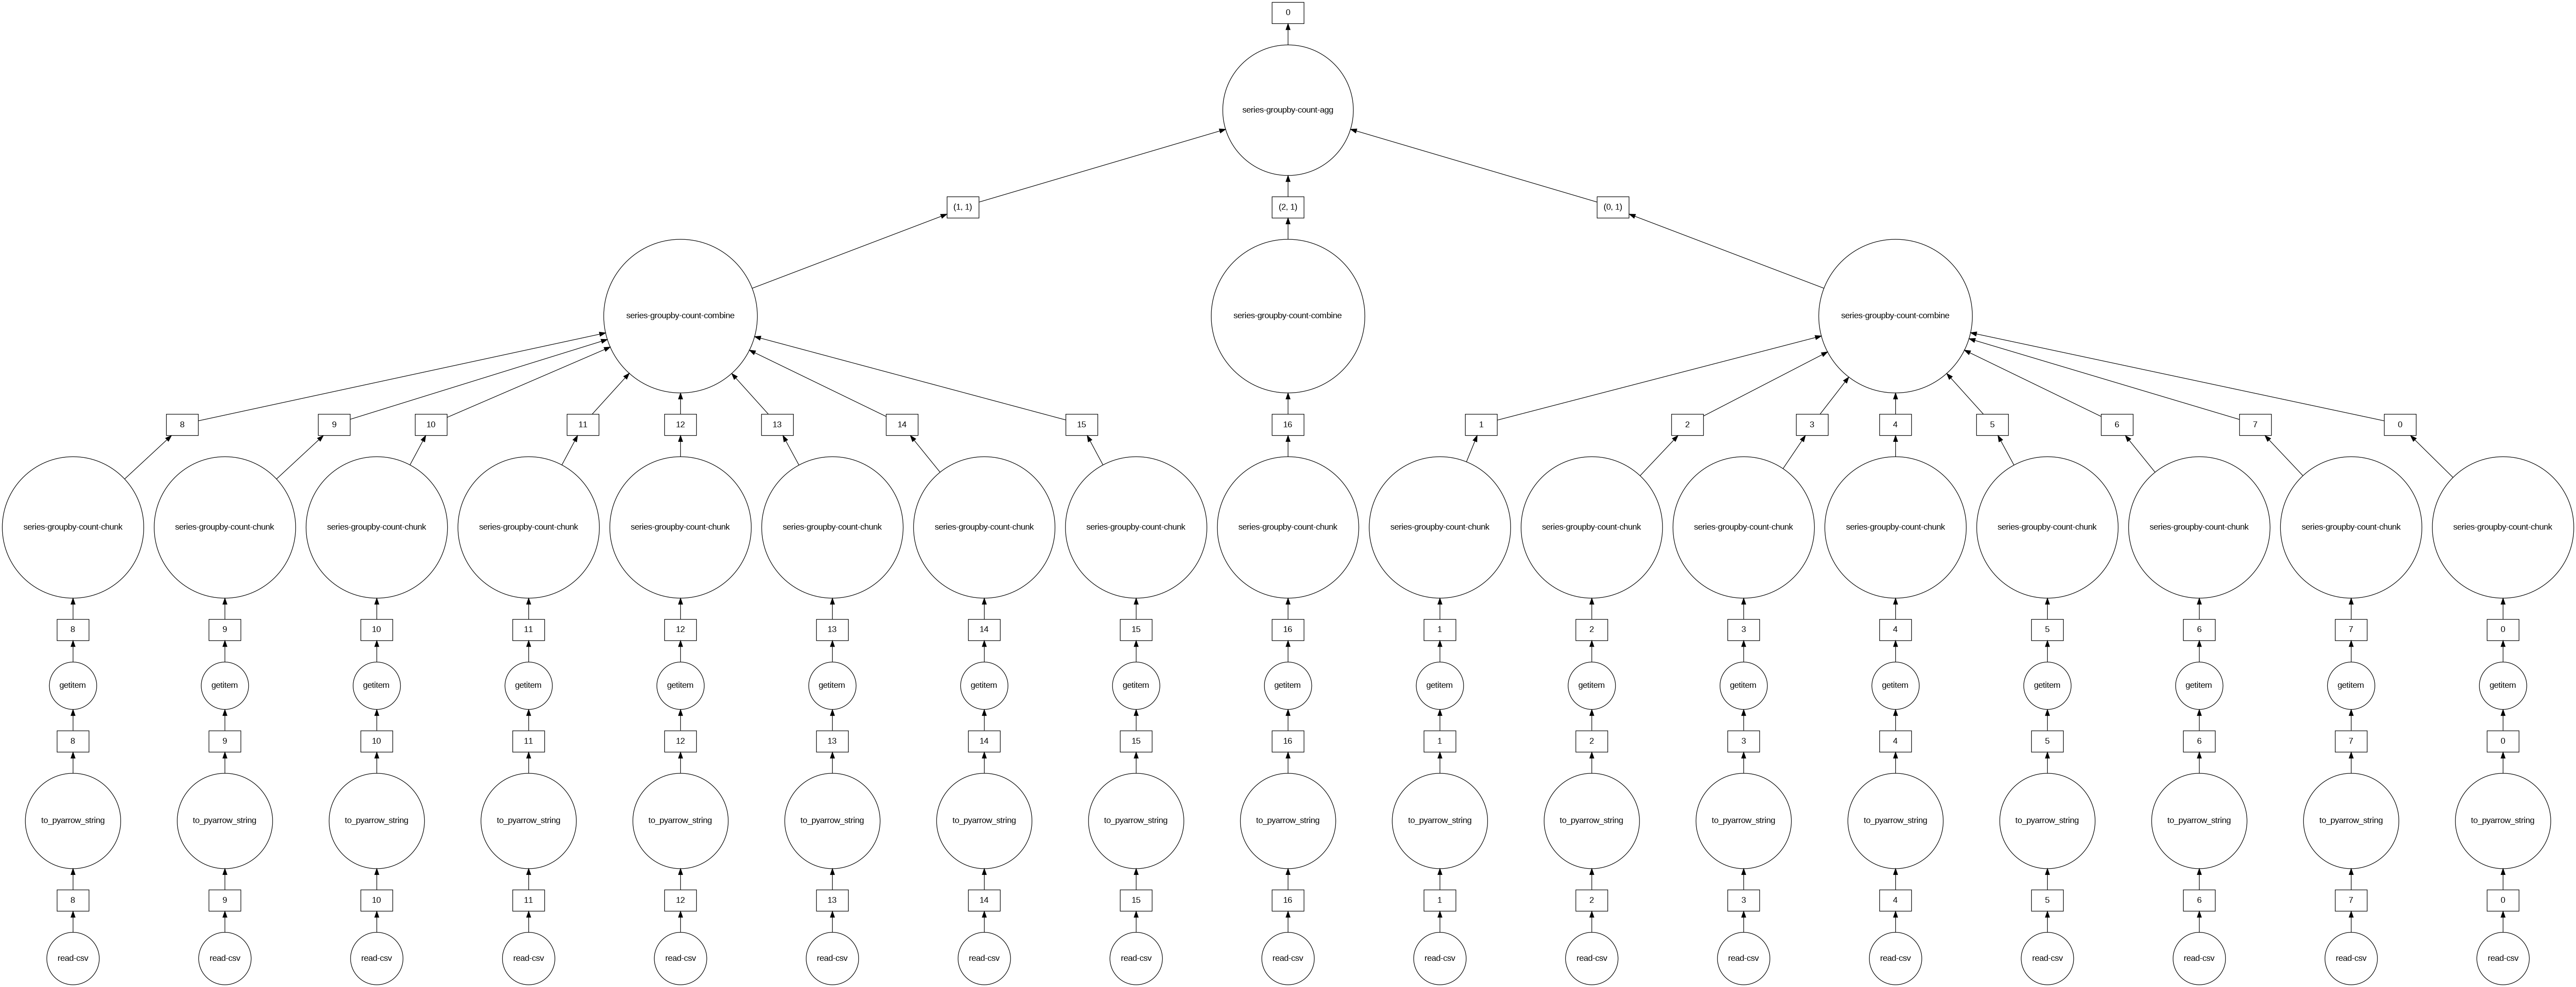

In [10]:
ddf_group = ddf.groupby("SHIFT")["OBJECTID"].count()
ddf_group.visualize()

When you are ready to actually turn a lazy computation into a computation, you can use the `.compute()` method, as seen below.

In [12]:
import time
s = time.time()
ddf_group.compute()
e = time.time()
print("Dask computation took {} seconds to run".format(str(round(e-s, 2))))

Dask computation took 5.2 seconds to run


... and some `comparison to Pandas for benchmarking.`

In [14]:
import pandas as pd
s = time.time()
fp = '/content/drive/MyDrive/Colab Notebooks/2025_Spring_DNSC4211/public/Class_05/Assignment/Data/'
dfs = [pd.read_csv(fp + i) for i in os.listdir(fp)]
df = pd.concat(dfs)
e = time.time()
print("Pandas took {} seconds to read in data".format(str(round(e-s, 2))))

Pandas took 5.77 seconds to read in data


In [15]:
import time
s = time.time()
print(df.groupby("SHIFT")["OBJECTID"].count())
e = time.time()
print("Pandas computation took {} seconds to run".format(str(round(e-s, 2))))

SHIFT
DAY         213816
EVENING     237337
MIDNIGHT    111164
Name: OBJECTID, dtype: int64
Pandas computation took 0.04 seconds to run


## Persist and Compute

`.compute()` and `.persist()`
- Relevant [documentaion](https://distributed.dask.org/en/latest/manage-computation.html#dask-collections-to-futures)
- Also useful: [link text](https://medium.com/@mameralomari1/dask-map-submit-persist-compute-an-overview-of-differences-570a696e7158#:~:text=persist%20allows%20you%20to%20persist,multiple%20times%20in%20a%20computation.)
- Nice explanation: [link text](https://stackoverflow.com/questions/41806850/dask-difference-between-client-persist-and-client-compute)

tl;dr;
It is recommended to use persist when your result is large and needs to be spread among many computers and using compute when your result is small and you want it on just one computer.


`Client.compute`

The `compute method` allows you to compute the result of a `Dask collection` or a Future object. The method blocks until the computation is complete and returns the result.


`Client.persist`

The `persist` method allows you to persist the computation of a `Dask collection` or a `Future object` in the worker's memory. This can be useful for large datasets that are used multiple times in a computation, as it avoids recomputing the same data multiple times.



In [16]:
'''
One example of this might be where we want to do a loc on a subset of data, then do various analytics
'''
#-- Filter data to be just in 2023
ddf_2023 = ddf.loc[ddf["REPORT_DAT"].str[0:4]=="2023"].persist()

... now we can use that calculation that we did to do other calculations, without calculating it over and over again, but also without committing everything into memory

In [17]:
ddf_2023["SHIFT"].value_counts().compute()

,count
SHIFT,
EVENING,13276
DAY,13097
MIDNIGHT,7852


In [18]:
ddf_2023["OFFENSE"].value_counts().compute()

,count
OFFENSE,
THEFT/OTHER,13263
THEFT F/AUTO,7748
MOTOR VEHICLE THEFT,6788
ROBBERY,3461
ASSAULT W/DANGEROUS WEAPON,1401
BURGLARY,1090
HOMICIDE,273
SEX ABUSE,190
ARSON,11


# Intro to Polars
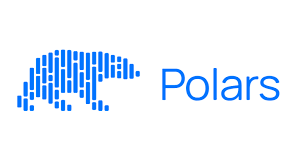

### About Polars
Polars is a blazingly fast DataFrame library for manipulating structured data. The core is written in Rust, and available for Python, R and NodeJS.

[Polars for Pandas users](https://docs.pola.rs/user-guide/migration/pandas/)

Key features
Fast: Written from scratch in Rust, designed close to the machine and without external dependencies.
- `I/O`: First class support for all common data storage layers: local, cloud storage & databases.
- `Intuitive API`: Write your queries the way they were intended. Polars, internally, will determine the most efficient way to execute using its query optimizer.
- `Out of Core`: The streaming API allows you to process your results without requiring all your data to be in memory at the same time.
- `Parallel`: Utilises the power of your machine by dividing the workload among the available CPU cores without any additional configuration.
Vectorized Query Engine
- `GPU Support`: Optionally run queries on NVIDIA GPUs for maximum performance for in-memory workloads.
- `Apache Arrow support`: Polars can consume and produce Arrow data often with zero-copy operations. Note that Polars is not built on a Pyarrow/Arrow implementation. Instead, Polars has its own compute and buffer implementations.`

### Polars Philosophy
The goal of Polars is to provide a lightning fast DataFrame library that:

Utilizes all available cores on your machine.
Optimizes queries to reduce unneeded work/memory allocations.
Handles datasets much larger than your available RAM.
A consistent and predictable API.
Adheres to a strict schema (data-types should be known before running the query).
Polars is written in Rust which gives it C/C++ performance and allows it to fully control performance-critical parts in a query engine.

<img src="https://pola.rs/_astro/perf-illustration.jHjw6PiD_165TDG.svg" width="400px"/>

### Interest in Polars Overtime

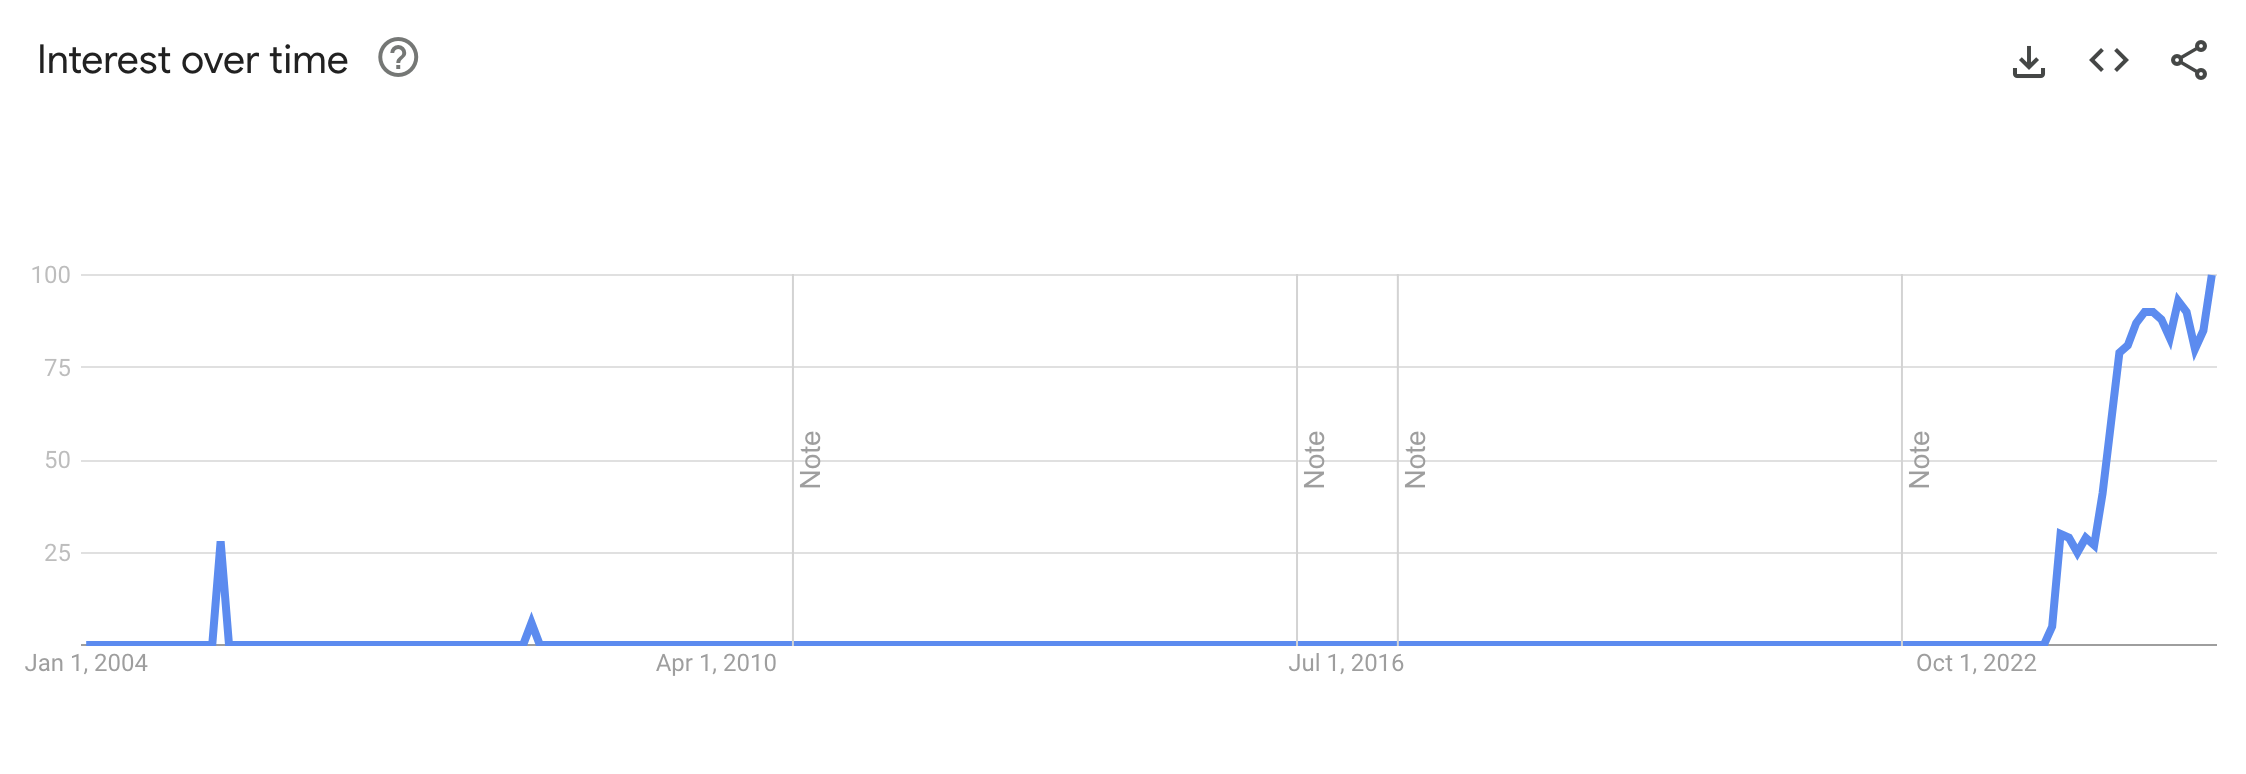

### Diving in

<script type="text/javascript" src="https://ssl.gstatic.com/trends_nrtr/4015_RC01/embed_loader.js"></script> <script type="text/javascript"> trends.embed.renderExploreWidget("TIMESERIES", {"comparisonItem":[{"keyword":"/g/11kqxzq2_d","geo":"US","time":"2004-01-01 2025-02-24"}],"category":0,"property":""}, {"exploreQuery":"date=all&geo=US&q=%2Fg%2F11kqxzq2_d&hl=en","guestPath":"https://trends.google.com:443/trends/embed/"}); </script>

In [ ]:
!pip install polars

In [19]:
import polars as pl

In [20]:

import os
path = '/content/drive/MyDrive/Colab Notebooks/2025_Spring_DNSC4211/public/Class_05/Assignment/Data/'
files = os.listdir(path)
queries = []
dtypes = {
    "CENSUS_TRACT":   float,
    "DISTRICT":       float,
    "PSA":            float,
    "XBLOCK":         float,
    "YBLOCK":         float,
    "WARD":           float
}
for f in files:
  df_ = pl.read_csv(path + f, schema_overrides=dtypes)
  queries.append(df_)
df = pl.concat(queries)


In [21]:
df.head(3)

X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,WARD,ANC,DISTRICT,PSA,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
f64,f64,i64,str,str,str,str,str,f64,f64,f64,str,f64,f64,str,str,f64,str,f64,f64,str,str,str,i64,str
-77.001271,38.956055,19154514,"""2019/08/31 19:20:04+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""5500 - 5599 BLOCK OF SOUTH DAK…",399890.0,143127.0,4.0,"""4B""",4.0,406.0,"""Cluster 19""","""009507 1""",9507.0,"""Precinct 65""",38.956047,-77.001269,null,"""2019/08/31 15:44:55+00""","""2019/08/31 16:45:32+00""",406078605,null
-76.982944,38.887599,10199597,"""2019/11/07 16:41:36+00""","""DAY""","""OTHERS""","""THEFT/OTHER""","""1500 - 1599 BLOCK OF INDEPENDE…",401480.0,135528.0,7.0,"""6B""",1.0,107.0,"""Cluster 26""","""006801 2""",6801.0,"""Precinct 87""",38.887592,-76.982941,null,"""2019/11/07 15:36:52+00""","""2019/11/07 16:42:02+00""",406079235,null
-77.010378,38.820469,17084415,"""2019/01/28 05:00:00+00""","""MIDNIGHT""","""GUN""","""HOMICIDE""","""130 - 199 BLOCK OF IRVINGTON S…",399099.0,128076.0,8.0,"""8D""",7.0,708.0,"""Cluster 39""","""010900 1""",10900.0,"""Precinct 126""",38.820461,-77.010375,null,"""2017/05/20 02:58:53+00""","""2017/05/20 06:26:45+00""",406079285,null


In [22]:
import time
s = time.time()
print(df.group_by("SHIFT").count())
e = time.time()
print("Dask computation took {} seconds to run".format(str(round(e-s, 2))))

shape: (3, 2)
┌──────────┬────────┐
│ SHIFT    ┆ count  │
│ ---      ┆ ---    │
│ str      ┆ u32    │
╞══════════╪════════╡
│ DAY      ┆ 213816 │
│ MIDNIGHT ┆ 111164 │
│ EVENING  ┆ 237337 │
└──────────┴────────┘
Dask computation took 0.11 seconds to run


<ipython-input-22-c3ba486659ab>:3: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  print(df.group_by("SHIFT").count())


### Column Slicing

Single column with...

In [23]:
df.get_column("SHIFT").head(5)

SHIFT
str
"""EVENING"""
"""DAY"""
"""MIDNIGHT"""
"""MIDNIGHT"""
"""DAY"""


or...

In [24]:
df["SHIFT"].head(5)

SHIFT
str
"""EVENING"""
"""DAY"""
"""MIDNIGHT"""
"""MIDNIGHT"""
"""DAY"""


Or multiple columns with...

In [25]:
df.select("SHIFT", "REPORT_DAT").head(3)

SHIFT,REPORT_DAT
str,str
"""EVENING""","""2019/08/31 19:20:04+00"""
"""DAY""","""2019/11/07 16:41:36+00"""
"""MIDNIGHT""","""2019/01/28 05:00:00+00"""


### Filtering

In [26]:
df.filter(
    (pl.col("SHIFT") == "EVENING") & (pl.col("OFFENSE") == "THEFT/OTHER")
)

X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,WARD,ANC,DISTRICT,PSA,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
f64,f64,i64,str,str,str,str,str,f64,f64,f64,str,f64,f64,str,str,f64,str,f64,f64,str,str,str,i64,str
-77.001271,38.956055,19154514,"""2019/08/31 19:20:04+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""5500 - 5599 BLOCK OF SOUTH DAK…",399890.0,143127.0,4.0,"""4B""",4.0,406.0,"""Cluster 19""","""009507 1""",9507.0,"""Precinct 65""",38.956047,-77.001269,null,"""2019/08/31 15:44:55+00""","""2019/08/31 16:45:32+00""",406078605,null
-77.07288,38.930449,19016965,"""2019/01/30 01:50:06+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""3000 - 3199 BLOCK OF WISCONSIN…",393681.0,140287.0,3.0,"""3C""",2.0,204.0,"""Cluster 14""","""000704 1""",704.0,"""Precinct 28""",38.930441,-77.072878,null,"""2019/01/24 22:23:00+00""","""2019/01/25 00:00:48+00""",406085210,null
-77.072294,38.921513,19016989,"""2019/01/30 03:07:57+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""2301 - 2499 BLOCK OF WISCONSIN…",393731.0,139295.0,3.0,"""3B""",2.0,204.0,"""Cluster 14""","""000300 1""",300.0,"""Precinct 11""",38.921505,-77.072292,null,"""2019/01/29 21:00:55+00""","""2019/01/29 23:00:50+00""",406085211,null
-77.005894,38.90605,19019721,"""2019/02/03 21:41:59+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""1200 - 1229 BLOCK OF 1ST STREE…",399489.0,137576.0,6.0,"""6C""",5.0,501.0,"""Cluster 25""","""010601 2""",10601.0,"""Precinct 144""",38.906042,-77.005891,"""NOMA""","""2019/02/03 20:44:00+00""",null,406085291,null
-76.995865,38.884547,19019839,"""2019/02/04 01:21:11+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""700 - 749 BLOCK OF PENNSYLVANI…",400359.0,135189.0,6.0,"""6B""",1.0,107.0,"""Cluster 26""","""006600 2""",6600.0,"""Precinct 89""",38.884539,-76.995862,"""CAPITOL HILL""","""2019/02/04 00:40:53+00""","""2019/02/04 00:45:29+00""",406085292,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
399117.4,128601.94,24009025,"""2024/01/19 01:26:11+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""20 - 199 BLOCK OF FORRESTER ST…",399117.4,128601.94,8.0,"""8D""",7.0,708.0,"""Cluster 39""","""009807 2""",9807.0,"""Precinct 126""",38.825199,-77.010164,null,"""2024/01/18 01:00:00+00""","""2024/01/18 16:00:00+00""",666776215,null
400121.38,137998.9,24173928,"""2024/11/08 23:47:38+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""1300 - 1399 BLOCK OF 4TH STREE…",400121.38,137998.9,5.0,"""5D""",null,501.0,"""Cluster 23""","""008803 2""",8803.0,"""Precinct 76""",38.909852,-76.998601,null,"""2024/11/08 23:30:00+00""","""2024/11/08 23:31:00+00""",666776218,null
400434.55,130257.12,24173984,"""2024/11/09 02:27:29+00""","""EVENING""","""OTHERS""","""THEFT/OTHER""","""714 - 799 BLOCK OF CONGRESS ST…",400434.55,130257.12,8.0,"""8C""",null,705.0,"""Cluster 39""","""009804 1""",9804.0,"""Precinct 122""",38.84011,-76.994995,null,"""2024/11/08 23:10:00+00""","""2024/11/08 23:12:00+00""",666776219,null


## From Pandas to Polars

If your `Polars code` looks like it could be pandas code, it might run, but it likely runs slower than it should.

### Be lazy
Working in lazy evaluation mode is straightforward and should be your default in Polars as the lazy mode allows Polars to do query optimization.

We can run in lazy mode by either using an implicitly lazy function (such as scan_csv) or explicitly using the lazy method.

Take the following simple example where we read a CSV file from disk and do a group by. The CSV file has numerous columns but we just want to do a group by on one of the id columns (id1) and then sum by a value column (v1). In pandas this would be:

```
#-- Pandas
df = pd.read_csv(csv_file, usecols=["id1","v1"])
grouped_df = df.loc[:,["id1","v1"]].groupby("id1").sum("v1")
```

In `Polars` you can build this query in lazy mode with query optimization and evaluate it by replacing the eager pandas function read_csv with the implicitly lazy Polars function `scan_csv`
```
#-- Lazy Polars
df = pl.scan_csv(csv_file)
grouped_df = df.group_by("id1").agg(pl.col("v1").sum()).collect()
```

In [27]:
!pwd

/content
